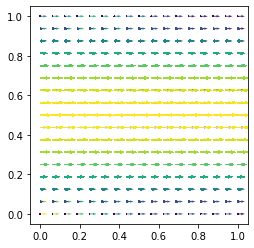

In [5]:
from __future__ import print_function
from fenics import *
import numpy as np

T = 10.0           # final time
num_steps = 500    # number of time steps
dt = T / num_steps # time step size
nu = 1             # kinematic viscosity
rho = 1            # density

# Create mesh and define function spaces
mesh = UnitSquareMesh(16, 16)
V = VectorFunctionSpace (mesh, 'P', 2)
Q = FunctionSpace (mesh, 'P', 1)

# Define boundaries
inflow  = 'near(x[0], 0)'
outflow = 'near(x[0], 1)'
walls   = 'near(x[1], 0) || near(x[1], 1)'

# Define boundary conditions
bcu_noslip  = DirichletBC(V, Constant((0, 0)), walls)
bcp_inflow  = DirichletBC(Q, Constant(8), inflow)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
bcu = [bcu_noslip]
bcp = [bcp_inflow, bcp_outflow]

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

# Define expressions used in variational forms
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
f   = Constant((0, 0))
k   = Constant(dt)
nu  = Constant(nu)
rho = Constant(rho)

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*nu*epsilon(u) - p*Identity(len(u))

# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx + \
     rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(nu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    # Plot solution
    plot(u_)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
